# Generalized Topic Embedding

In [13]:
from utils import * 
from lda_embedder.lda_model import LDAembedder
import pickle
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

Individual reviews contain too much variance, and cannot generalize the topic distribution enough. We are going to explore more robust high dimensional embedding

In [2]:
# load data
chinese_business = pd.read_csv('chinese_business.csv', index_col = False)
chinese_reviews = pd.read_csv('chinese_review_clean.csv', index_col = False)

In [3]:
# load pre-trained topic models
with open("model/chinese_counter.pkl", "rb") as f:
        vectorizer = pickle.load(f)
with open("model/chinese.pkl", "rb") as f:
        topic_model = pickle.load(f)
lda = LDAembedder(model = topic_model, counter = vectorizer)

In [4]:
x = lda.embed(chinese_reviews['text'].values[5], method = 'additive')
y = lda.embed(chinese_reviews['text'].values[5], method = 'multiplicative')

In [5]:
chinese_reviews['text'].values[5]

'Decent customer service but the food was awful. It was cold and had no sauce at all. I was expecting it to be good but this place really went down hill. I will never eat here again.'

## Autoencoder

In [6]:
class AutoEncoder(object):
    '''
    Simple implementation of auto-encoder
    '''
    def __init__(self, k, hidden):
        self.n_input = k
        self.n_hidden = hidden
        self.weights = {
            'encoder_h': tf.Variable(tf.random_normal([self.n_input, self.n_hidden], dtype=tf.float32)),
            'decoder_h': tf.Variable(tf.random_normal([self.n_hidden, self.n_input], dtype=tf.float32)),
        }
        self.biases = {
            'encoder_b': tf.Variable(tf.random_normal([self.n_hidden], dtype=tf.float32)),
            'decoder_b': tf.Variable(tf.random_normal([self.n_input], dtype=tf.float32)),
        }
        self.X = tf.placeholder(tf.float32, [None, self.n_input])

    def encoder(self, x):
        feed = tf.add(tf.matmul(x, self.weights['encoder_h']), self.biases['encoder_b'])
        layer = tf.nn.sigmoid(feed)
        return layer

    def decoder(self, x):
        feed = tf.add(tf.matmul(x, self.weights['decoder_h']), self.biases['decoder_b'])
        layer = tf.nn.sigmoid(feed)
        return layer

In [66]:
model = AutoEncoder(128, 10)

encoder_op = model.encoder(model.X)
decoder_op = model.decoder(encoder_op)

y_pred = decoder_op
y_true = model.X


batch_size = 20
training_epochs = 200
learning_rate = 0.01
display_step = 10

cost = tf.reduce_mean(tf.pow(tf.multiply(y_true - y_pred, 100), 2))
regularizer = tf.reduce_mean(tf.nn.l2_loss(model.weights['encoder_h']))
# cost = tf.reduce_mean(cost + 0.01 * regularizer)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(len(chinese_reviews)/batch_size)
    for epoch in range(training_epochs):
        for i in range(100):
            indecies = random.sample(range(len(chinese_reviews_clean)), batch_size)
            batch_xs = [lda.embed(i) for i in chinese_reviews_clean.iloc[indecies]['text']]
            _, c = sess.run([optimizer, cost], feed_dict={model.X: batch_xs})
        if epoch % display_step == 0:
            y = sess.run(y_pred, feed_dict={model.X: batch_xs[0].reshape(1,-1)})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
        if epoch == 0:   
            print ("true: {}".format(batch_xs[0]))
            print ("pred: {}".format(y))
        if epoch == training_epochs-1:   
            print ("true: {}".format(batch_xs[0]))
            print ("pred: {}".format(y))

Epoch: 0001 cost= 23.911403656
true: [ 0.00624469  0.00624469  0.01304741  0.00964605  0.00624469  0.00964605
  0.00624469  0.00964605  0.00624469  0.00624469  0.01304741  0.00624469
  0.00624469  0.00624469  0.00624469  0.00624469  0.01304741  0.00624469
  0.00624469  0.00624469  0.01304741  0.00624469  0.00624469  0.00964605
  0.01644877  0.00624469  0.00624469  0.00624469  0.00624469  0.00624469
  0.00624469  0.00624469  0.00624469  0.01161978  0.00624469  0.00624469
  0.00624469  0.01644877  0.01644877  0.00624469  0.01304741  0.00624469
  0.00624469  0.00624469  0.00624469  0.01304741  0.00624469  0.00624469
  0.00624469  0.00624469  0.00624469  0.00624469  0.00624469  0.00964605
  0.00964605  0.00624469  0.0082942   0.00964605  0.00964605  0.00964605
  0.00624469  0.00964605  0.00624469  0.00624469  0.00624469  0.00964605
  0.00624469  0.00964605  0.00624469  0.00964605  0.00624469  0.00624469
  0.00759653  0.00624469  0.00624469  0.00964605  0.00624469  0.00624469
  0.00624469  

The model seems to be able to reconstruct some topics, but not all of them. This is an expected behavior since I deconstructed to 10% of original dimension

Some reviews are breaking my code...

In [57]:
chinese_reviews.iloc[[83656, 83000+45621]]

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
83656,mpG1R1ktTI3x1twNBsGvXQ,0,2015-07-05,0,XTjQvPiXiLSkYXWGrH_taQ,5,v,0,CVhY1u5ZN4MidNWnRC-V6g
128621,6ZsiLiSWGK2pgw6t3LfzNQ,0,2013-09-30,0,LyyrSgdpmDbJODdrH_GP5Q,5,y,2,0kXhQEQHGVYVA-oxK8RrFQ


Thanks for breaking my code, 'CVhY1u5ZN4MidNWnRC-V6g' and '0kXhQEQHGVYVA-oxK8RrFQ'!

In [61]:
chinese_reviews_clean = chinese_reviews.drop(chinese_reviews.index[[83656, 83000+45621]])

In [63]:
chinese_reviews_clean.to_csv('chinese_review_clean.csv', index = False)

Train over night...

In [36]:
error_rate = {}
for layer in [100, 50, 30, 10]:
    model = AutoEncoder(128, 10)
    error = []
    encoder_op = model.encoder(model.X)
    decoder_op = model.decoder(encoder_op)

    y_pred = decoder_op
    y_true = model.X


    batch_size = 20
    training_epochs = 200
    learning_rate = 0.01
    display_step = 20

    print ('Hidden layer size: {}'.format(layer))
    cost = tf.reduce_mean(tf.pow(tf.multiply(y_true - y_pred, 100), 2))
    regularizer = tf.reduce_mean(tf.nn.l2_loss(model.weights['encoder_h']))
    # cost = tf.reduce_mean(cost + 0.01 * regularizer)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        total_batch = int(len(chinese_reviews)/batch_size)
        for epoch in range(training_epochs):
            for i in range(100):
                indecies = random.sample(range(len(chinese_reviews)), batch_size)
                batch_xs = [lda.embed(i) for i in chinese_reviews.iloc[indecies]['text']]
                _, c = sess.run([optimizer, cost], feed_dict={model.X: batch_xs})
               
            if epoch % display_step == 0:
                y = sess.run(y_pred, feed_dict={model.X: batch_xs[0].reshape(1,-1)})
                print("Epoch:", '%04d' % (epoch+1),
                      "cost=", "{:.9f}".format(c))
            error.append(c)
    error_rate[layer] = error

Hidden layer size: 100
Epoch: 0001 cost= 22.100334167
Epoch: 0021 cost= 0.269715965
Epoch: 0041 cost= 0.341990530
Epoch: 0061 cost= 0.310302556
Epoch: 0081 cost= 0.326591790
Epoch: 0101 cost= 0.261363357
Epoch: 0121 cost= 0.259901375
Epoch: 0141 cost= 0.168252781
Epoch: 0161 cost= 0.146825165
Epoch: 0181 cost= 0.236113816
Hidden layer size: 50
Epoch: 0001 cost= 17.522411346
Epoch: 0021 cost= 0.863735020
Epoch: 0041 cost= 0.278944552
Epoch: 0061 cost= 0.275486648
Epoch: 0081 cost= 0.521224976
Epoch: 0101 cost= 0.350706637
Epoch: 0121 cost= 0.233133763
Epoch: 0141 cost= 0.201817781
Epoch: 0161 cost= 0.249723032
Epoch: 0181 cost= 0.272411972
Hidden layer size: 30
Epoch: 0001 cost= 17.007146835
Epoch: 0021 cost= 0.255461872
Epoch: 0041 cost= 0.377196074
Epoch: 0061 cost= 0.279326975
Epoch: 0081 cost= 0.208761737
Epoch: 0101 cost= 0.211492211
Epoch: 0121 cost= 0.281580269
Epoch: 0141 cost= 0.258425862
Epoch: 0161 cost= 0.176994115
Epoch: 0181 cost= 0.176683456
Hidden layer size: 10
Epoch: 0

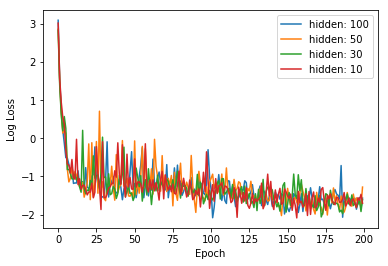

In [43]:
legends = []
for i in error_rate.keys(): 
    plt.plot(np.log(np.array(error_rate[i])))
    legends.append('hidden: {}'.format(i))
plt.legend(legends)    
plt.ylabel('Log Loss')
plt.xlabel('Epoch')
plt.show()

In [45]:
pd.DataFrame(error_rate)

,10,30,50,100
0,20.495331,17.007147,17.522411,22.100334
1,4.796838,4.038508,4.353036,4.584476
2,2.590190,1.865125,1.999747,2.234864
3,1.753307,1.216249,1.148472,1.249645
4,1.460268,1.771143,1.235220,0.882635
5,0.728994,1.300523,1.142534,0.603014
6,0.510305,0.440905,0.445568,0.595890
7,0.495020,0.443611,0.318954,0.504959
8,0.402199,0.395633,0.351245,0.419611
9,0.574474,0.345627,0.477001,0.473758
